In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import *
from math import *

In [2]:
from jupyterthemes import jtplot  
jtplot.style(grid=False)
# This is a library for fancier looking plots
# If this cell gives off an error, than feel free to remove these 2 lines

In [3]:
import warnings
warnings.filterwarnings('ignore')

Author: Mahmoud EL OMAR : M1 - CORO IMARO.

Artificial Intelligence Report : Lab2 - Clustering

# Data
In this lab, we will consider two types of data : 
\begin{enumerate}
\item Synthetic 2-dimensional data split into 10 clusters along the $y=x$ axis
\item A realistic N-dimesional data set, read from a csv file
\end{enumerate}
The synthetic data serves as a proof of concept since it's more easy to visualize
The function below is the one we're gonna use to generate the synthetic data

In [4]:
def getSynData(synNbClasses = 10,overlapping_coeff = 1,noise_coeff = 1):
    syn = np.empty([2, 0])
    synLabels = []
    for k in range(synNbClasses):
        syn = np.concatenate((syn, noise_coeff*np.random.rand(2, 100)+overlapping_coeff*k), axis=1)
        synLabels = np.concatenate((synLabels, np.ones(100)*k))
    return syn.T,synLabels

(1000, 2)


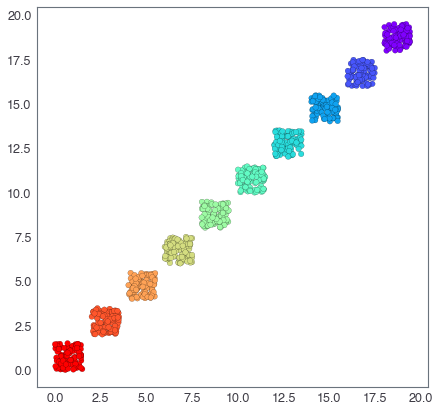

In [5]:
syn,synLabels = getSynData(overlapping_coeff=2,noise_coeff=1.5)
print(syn.shape)
plt.figure(figsize=(7,7))
plt.scatter(syn[:,0], syn[:,1], c = 10 - synLabels, cmap = 'rainbow', edgecolors = 'black')
plt.show()

In the cell below, we see the snippet of code in which we import the real dataset

In [6]:
rea1 = np.loadtxt('./data/data1.csv')
rea2 = np.loadtxt('./data/data2.csv')
rea = np.concatenate((rea1, rea2))

reaLabels = rea[:, 0]
rea = rea[:, 1:]

# Evaluation Metric
The metric we'll use to evaluate the performance of our clustering models is the \textit{Adjusted Mutual Information}  : 

\begin{equation}
    AMI(X,Y) = \frac{I(X;Y) - E\{ I(X;Y)\}}{max\{ H(X),H(Y)\} - E\{ I(X;Y)\}}
\end{equation}
With $I(X;Y)$ being the mutual information between the two random variables $X$ and $Y$. 

And $H(X), H(Y)$ being the respective entropies of the random variables $X$ and $Y$

$E\{ I(X;Y)\} $ is the expectation of the mutual information

See [\textit{Information Theory}](https://en.wikipedia.org/wiki/Information_theory)

# Euclidean Space Clustering
In the next cell, we will implement the KMeans Algorithm on the synthetic data, taking the euclidean norm as our distance (Minkowski distance with $p = 2$)

In [7]:
synModel = sklearn.cluster.KMeans(n_clusters = 10)
synOutput = synModel.fit(syn)
synScore = sklearn.metrics.adjusted_mutual_info_score(synLabels,synOutput.labels_)
print("The score of our KMeans model for the synthetic data is the following : "+str(synScore))

The score of our KMeans model for the synthetic data is the following : 1.0


Now, we will repeat the same thing, but on our more realistic N-dimensional dataset

In [9]:
reaModel = sklearn.cluster.KMeans(n_clusters=len(set(reaLabels)))
reaOutput = reaModel.fit(rea)
reaScore = sklearn.metrics.adjusted_mutual_info_score(reaLabels, reaOutput.labels_)
print("The score of our KMeans model for the realistic data is the following : "+str(reaScore))

The score of our KMeans model for the realistic data is the following : 0.8999213285069089


# Model Selection
Now, we will implement the Gap Statistics Criterion, to the see the robustness of our model, and how the loss evolves with respect to the number of clusters we look for.
The inertia  of the KMeans model is the  within-cluster sum-of-squares : 
\begin{equation}
    \sum_{i = 0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)
\end{equation}
The KMeans algorithm aims to minimize this measure.
The Gap Statistics is the ratio of the Inertia of KMeans performed on random data, and the Inertia of KMeans performed on our target data. We will see how this criterion evoles as a function of the number of  the clusters we chose to look for.

This can also serve to find the optimum number of clusters $k$ when we don't know it a priori 

## Gap Statistic Criterion for Synthetic Data

We will begin to do that for the synthetic data

In [10]:
synGapVector = []

randomSyn = np.random.rand(syn.shape[0],syn.shape[1])

for k in range(40): # the number of clusters would belong the interval [1,40].
    randomModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(syn)
    synModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(randomSyn)
    current_gap = randomModel.inertia_/reaModel.inertia_
    synGapVector.append(current_gap)

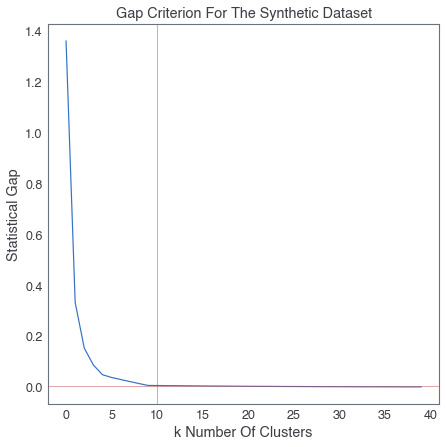

In [11]:
plt.figure(figsize=(7,7))
plt.plot(range(len(synGapVector)),synGapVector)
plt.axvline(x = 10, linewidth = 0.5,color = 'r') # plots vertical line
plt.axhline(y = synGapVector[10],linewidth = 0.5,color = 'r') # plots horizontal line

plt.xlabel("k Number Of Clusters")
plt.ylabel("Statistical Gap")

plt.title("Gap Criterion For The Synthetic Dataset")

plt.show()

In the plot above, we see the plot of the Gap Statistics as a function of the number of clusters. We can evidently see it decreasing monotonically as the number of clusters increases. But after a specific number of clusters, we can see that the gap flattens and the decrease is no longer noticeable. That location at the "elbow" of the plot indicates the appropiate number of clusters we should adopt, and above which we would be increasing the computational costs without improving the performance of the model. So it's not wise at all to chose a number of clusters that lies beyond the "elbow".

From the plot above, we can see that the appropriate number of clusters is indeed $10$.

Now, let's increase the overlapping of the clusters in the synthetic dataset and see what happens.

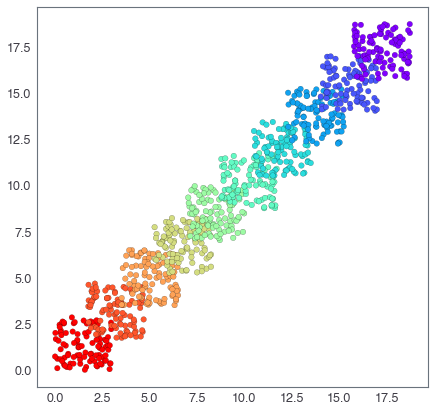

In [12]:
syn_1,synLabels_1 = getSynData(overlapping_coeff=1.75,noise_coeff=3)
plt.figure(figsize=(7,7))
plt.scatter(syn_1[:,0], syn_1[:,1], c = 10 - synLabels_1, cmap = 'rainbow', edgecolors = 'black')
plt.show()

In [13]:
synGapVector_1 = []

randomSyn = np.random.rand(syn.shape[0],syn.shape[1])

for k in range(40): # the number of clusters would belong the interval [1,40].
    randomModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(syn_1)
    synModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(randomSyn)
    current_gap = randomModel.inertia_/reaModel.inertia_
    synGapVector_1.append(current_gap)

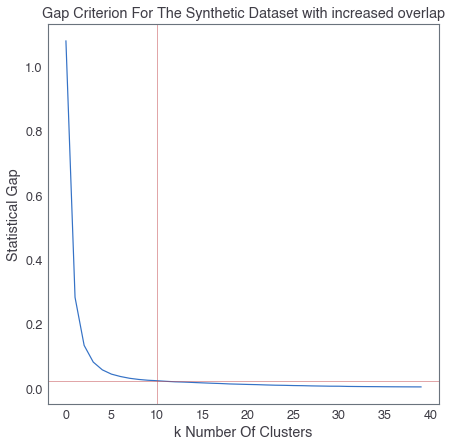

In [14]:
plt.figure(figsize=(7,7))
plt.plot(range(len(synGapVector_1)),synGapVector_1)
plt.axvline(x = 10, linewidth = 0.5,color = 'r') # plots vertical line
plt.axhline(y = synGapVector_1[10],linewidth = 0.5,color = 'r') # plots horizontal line

plt.xlabel("k Number Of Clusters")
plt.ylabel("Statistical Gap")

plt.title("Gap Criterion For The Synthetic Dataset with increased overlap")

plt.show()

After increasing the overlap as shown in the previous scatter plot, we can still see that the "elbow" is still located at k = 10, the decrease is more noticeable than before, but still ultimately not worth the extra computation.

In the following cell, we'll increase the overlapping by much more than before. We'll discover in the scatter plot below that the clusters structure is pretty much gone.

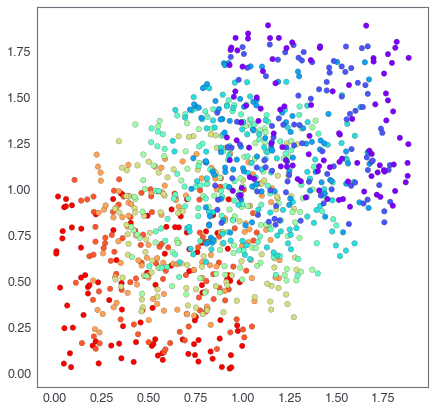

In [15]:
syn_2,synLabels_2 = getSynData(overlapping_coeff=0.1,noise_coeff=1)
plt.figure(figsize=(7,7))
plt.scatter(syn_2[:,0], syn_2[:,1], c = 10 - synLabels_2, cmap = 'rainbow', edgecolors = 'black')
plt.show()

In [16]:
synGapVector_2 = []

randomSyn = np.random.rand(syn.shape[0],syn.shape[1])

for k in range(40): # the number of clusters would belong the interval [1,40].
    randomModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(syn_2)
    synModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(randomSyn)
    current_gap = randomModel.inertia_/reaModel.inertia_
    synGapVector_2.append(current_gap)

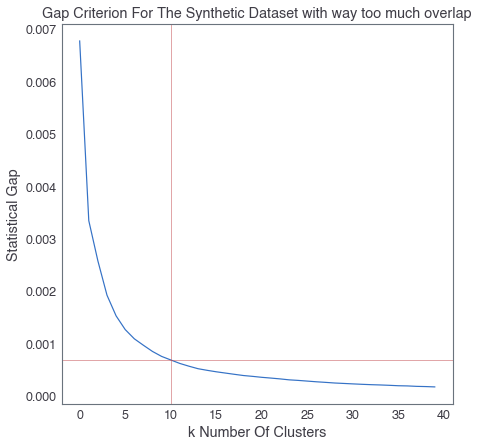

In [17]:
plt.figure(figsize=(7,7))
plt.plot(range(len(synGapVector_2)),synGapVector_2)
plt.axvline(x = 10, linewidth = 0.5,color = 'r') # plots vertical line
plt.axhline(y = synGapVector_2[10],linewidth = 0.5,color = 'r') # plots horizontal line

plt.xlabel("k Number Of Clusters")
plt.ylabel("Statistical Gap")

plt.title("Gap Criterion For The Synthetic Dataset with way too much overlap")

plt.show()

After increasing the overlapping of the clusters way too much, we're starting to see the statistical gap still decreases considerably after what used to be the "elbow" in previous cases. One would be quick to judge that a higher number of clusters automatically means a better model. However that would be wrong, because if we increase the number of clusters to the limit, we'll end up assigning a unique cluster to each point, which is definitely NOT what we're looking for. In the case of too much overlapping, the data is just too noisy. So the statistic is not robust in the case of overlapping clusters

This is what we call a trivial solution that minimises the loss function. In this case, it sets the loss function to zero. We should avoid trivial solutions when implementing any optimisation algorithm.

## Gap Statistic Criterion for realistic data

We will now implement the Gap Statistics Criterion on the realistic N-dimensional dataset

In [18]:
reaGapVector = []

randomRea = np.random.rand(rea.shape[0],rea.shape[1])

for k in range(40):
    randomModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(rea)
    reaModel = sklearn.cluster.KMeans(n_clusters= k + 1).fit(randomRea)
    current_gap = randomModel.inertia_/reaModel.inertia_
    reaGapVector.append(current_gap)

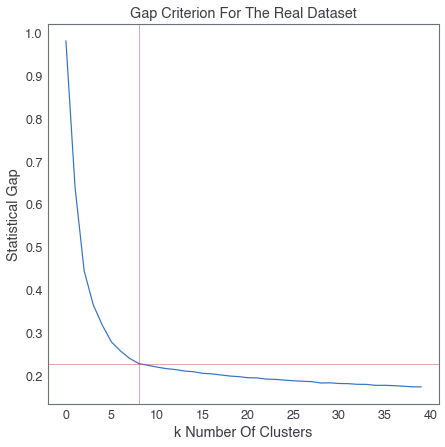

In [19]:
plt.figure(figsize=(7,7))
plt.plot(range(len(reaGapVector)),reaGapVector)

plt.axvline(x = 8, linewidth = 0.5,color = 'r')
plt.axhline(y = reaGapVector[8],linewidth = 0.5,color = 'r')

plt.xlabel("k Number Of Clusters")
plt.ylabel("Statistical Gap")
plt.title("Gap Criterion For The Real Dataset")

plt.show()

We can see, by inspection, from the plot above that "elbow" lies at $k = 8$ clusters. We could say the gap criterion allowed us to pick the correct number of clusters in the case of real data

# Non Euclidean Clustering (Spectral Clustering)

The spectral clustering algorithm is implemented step by step as indicated in the given.

We begin by writing the RBF kernel function in the cell below. 
\begin{equation}
    RBF(x,y) = -e^{\frac{||x-y||^2}{2\sigma^2}}
\end{equation}

The way I implemented the RBF kernel below, allows me to skip the step where we compute the matrix of pairwise euclidean distance, and it allows me to directly compute the matrix of weights $W$

In [33]:
def rbf(x,y,sigma = 1):
    n = np.linalg.norm(x-y)**2
    n /= (2*sigma*sigma)
    return np.exp(-n)
def getAdjancencyMatrix(X,sigma = 1.0,kernel = 'rbf'):
    W = np.zeros([X.shape[0],X.shape[0]])
    for p in range(X.shape[0]):
        x = X[p,:]
        for j in range(p,X.shape[0]):
            y = X[j,:]
            if kernel == 'rbf':
                W[p,j] = rbf(x,y,sigma = sigma)
            elif kernel == 'normal':
                W[p,j] = np.linalg.norm(x-y)**2
            W[j,p] = W[p,j]
    return W
def spectralClustering(X,nbClusters,sigma = 1):
    assert nbClusters >= 2 ," Really ? You're looking for only one cluster ??"
    W = getAdjancencyMatrix(X,sigma = sigma)
    W -= np.eye(W.shape[0]) 
    # making the diagonals zero, because there is no edge connecting
    # a point to itself in the graph, therefore according to graph theory,
    # the diagonals in the weighted adjancency matrix should be zero
    D = np.diag(W.sum(axis=1))
    L = D - W
    s, Vh = np.linalg.eig(L)
    Vh = Vh[:,np.argsort(s)]  # sorting the eigenvectors 
    s = s[np.argsort(s)]      # sorting the eigenvalues in increasing order
    eigenvector = Vh.real[:,:nbClusters].copy() 
    # taking the first K eigenvectors into account, 
    # because we are interested in finding 10 clusters
    #eigenvector /= np.linalg.norm(eigenvector,axis = 0) # normalize
    #Performing the KMeans on the eigenvectors
    
    spectralModel = sklearn.cluster.KMeans(n_clusters=nbClusters)
    spectralOuput = spectralModel.fit(eigenvector)
    return spectralOuput, s, Vh

In [34]:
spectralOuput,s, Vh = spectralClustering(syn,10,sigma = 1)

Text(0.5, 1.0, 'Visualisation of Spectral Output labels')

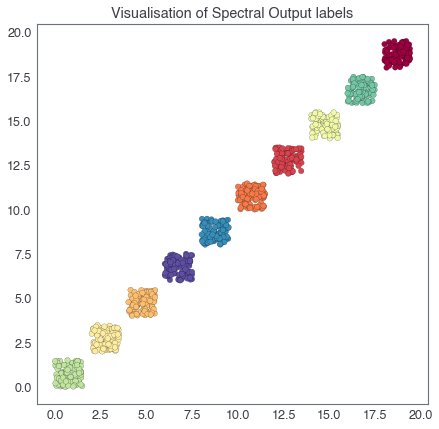

In [35]:
plt.figure(figsize=(7,7))
plt.scatter(syn[:,0], syn[:,1], c = spectralOuput.labels_, cmap='Spectral', 
            edgecolors='black')
plt.title("Visualisation of Spectral Output labels")

We'll display a staircase plot of the eigenvalues in the cell below

Text(0.5, 1.0, 'Staircase plot of the 10 first eigenvalues')

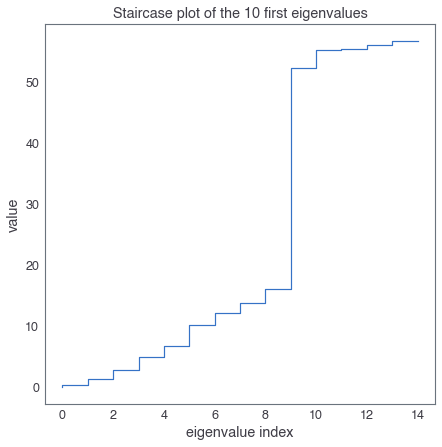

In [36]:
plt.figure(figsize=(7,7))
plt.step(range(len(s[...,:15])),s[...,:15])
plt.xlabel('eigenvalue index')
plt.ylabel('value')
plt.title("Staircase plot of the 10 first eigenvalues")

We can see from the plot above that the eigenvector decomposition of the laplacian of the synthetic dataset is indeed step wise.

We now shall try the packaged spectral clustering algorithm that comes with scikit-learn library, and see how it performs on the syn dataset

In [37]:
adjacency_matrix = getAdjancencyMatrix(syn)
sc = sklearn.cluster.SpectralClustering(10, affinity='precomputed', n_init=100,
                        assign_labels='kmeans')
sk_spectral_labels_out = sc.fit_predict(adjacency_matrix)  
print("The AMI score of the scikit-learn's own spectral clustering implementation, in the case of synthetic data, is "+str(adjusted_mutual_info_score(synLabels,sk_spectral_labels_out)))

The AMI score of the scikit-learn's own spectral clustering implementation, in the case of synthetic data, is 1.0


In [38]:
rea_adjacency_matrix = getAdjancencyMatrix(rea)
sc = sklearn.cluster.SpectralClustering(8, affinity='precomputed', n_init=100,
                        assign_labels='kmeans')
sk_spectral_labels_out = sc.fit_predict(rea_adjacency_matrix)  
print("The AMI score of the scikit-learn's own spectral clustering implementation, in the case of the realistic data, is " + str(adjusted_mutual_info_score(reaLabels,sk_spectral_labels_out)))

The AMI score of the scikit-learn's own spectral clustering implementation, in the case of the realistic data, is 0.5016533909555771


The SpectralClustering class in the scikit-learn library performs just as well as our own implementation. 

In [43]:
sigmas = np.arange(0.01,10,0.5)
print("Number of Sigmas : "+str(len(sigmas)))
scores = []
for i in range(len(sigmas)):
    spectralOuput,_,_ = spectralClustering(syn,10,sigma = sigmas[i])
    current_score = adjusted_mutual_info_score(synLabels,spectralOuput.labels_)
    scores.append(current_score)
    print(str(i) + "th Iteration. Score : " + str(current_score) + " | Sigma : "+str(sigmas[i]))

Number of Sigmas : 20
0th Iteration. Score : 0.018769406548532507 | Sigma : 0.01
1th Iteration. Score : 1.0 | Sigma : 0.51
2th Iteration. Score : 1.0 | Sigma : 1.01
3th Iteration. Score : 1.0 | Sigma : 1.51
4th Iteration. Score : 0.7920039398621844 | Sigma : 2.01
5th Iteration. Score : 0.755773638791977 | Sigma : 2.51
6th Iteration. Score : 0.6343401227660639 | Sigma : 3.01
7th Iteration. Score : 0.5897686017128981 | Sigma : 3.51
8th Iteration. Score : 0.5437652838713587 | Sigma : 4.01
9th Iteration. Score : 0.5125163173635389 | Sigma : 4.51
10th Iteration. Score : 0.4441106744957 | Sigma : 5.01
11th Iteration. Score : 0.40502683002741546 | Sigma : 5.51
12th Iteration. Score : 0.40835059783908456 | Sigma : 6.01
13th Iteration. Score : 0.4083505978390845 | Sigma : 6.51
14th Iteration. Score : 0.40835059783908456 | Sigma : 7.01
15th Iteration. Score : 0.34159956581509315 | Sigma : 7.51
16th Iteration. Score : 0.34159956581509315 | Sigma : 8.01
17th Iteration. Score : 0.311265072253379 | 

Below, lies the plot depicting how well spectral clustering performs as $\sigma$ varies from $0.01$ until $10$

By inspection, we see that, in the case of our synthetic data, we have several optimal values for $\sigma$, one of those is $\sigma = 1.0$ 


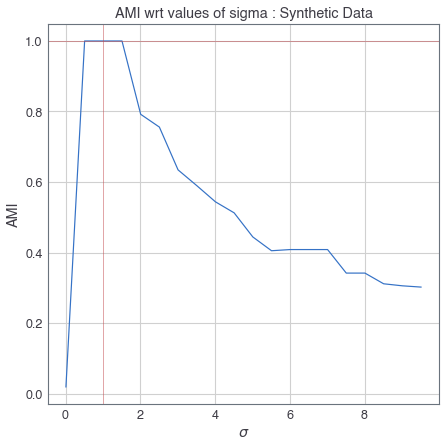

In [44]:
plt.figure(figsize=(7,7))
plt.plot(sigmas,scores)
plt.axhline(y = 1.0, color = 'r', linewidth = 0.5)
plt.axvline(x = 1.0, color = 'r', linewidth = 0.5)
plt.xlabel("$σ$")
plt.ylabel('AMI')
plt.title("AMI wrt values of sigma : Synthetic Data")
plt.grid(True)

In [47]:
sigmas = np.arange(0.01,5,0.5)
print(len(sigmas))
rea_scores = []
for sigma in sigmas:
    spectralOuput,_,_ = spectralClustering(rea,8,sigma = sigma)
    current_score = adjusted_mutual_info_score(reaLabels,spectralOuput.labels_)
    print(current_score)
    rea_scores.append(current_score)

10
0.0020587860952403863
0.008619613771597059
0.6032968279165495
0.6361235301540246
0.6354270876503435
0.635412963874371
0.5414073269700548
0.5400475374735737
0.5376435808309381
0.5332466686325115


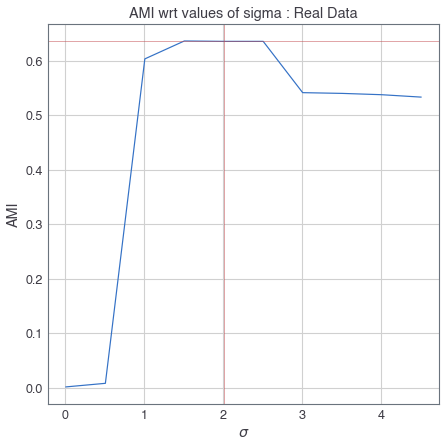

In [54]:
index = 4
plt.figure(figsize=(7,7))
plt.plot(sigmas,rea_scores)
plt.axhline(y = rea_scores[index], color = 'r', linewidth = 0.5)
plt.axvline(x = sigmas[index], color = 'r', linewidth = 0.5)
plt.xlabel("$σ$")
plt.ylabel('AMI')
plt.title("AMI wrt values of sigma : Real Data")
plt.grid(True)

We evidently see beyond any doubt that spectral clustering performance has an upper bound at 0.63 for $\sigma$ = 2 

For the realistic data, it seems that our own spectral clustering performs better than scikit-learn's implementation, but not better than scikit-learn's kMeans implementation that gave an AMI score of almost 0.9

# Conclusion

|  | Synthetic 2-d Data | Realistic N-d Data|
| --- | --- | --- |
| \textbf{kMeans (Euclidean Clustering)} | 1.0 | 0.8999|
| \textbf{Spectral Clustering (Own Implementation)} | 1.0  $\:$ ($\sigma = 1$) | 0.63 $\:$  ($\sigma = 2$) |
| \textbf{Spectral Clustering (scikit-learn's own implementation)} | 1.0 | 0.501 |

<br/>
This table compiles the optimal results obtained in this notebook and displays them right next to their hyperparameter values. 

The performance of the models displayed above can surely be improved if we are to count on them in real life applications.

With this, we bring an end to this lab report with the correspondent code. 